In [1]:
date()

[1] "Wed Jan 04 22:18:47 2017"

In [2]:
sapply(c("pipeR", "dplyr", "tidyr", "purrr", "ggplot2", "readr"), require, character.only= TRUE)

Loading required package: pipeR
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: purrr

Attaching package: 'purrr'

The following objects are masked from 'package:dplyr':

    contains, order_by

Loading required package: ggplot2
Loading required package: readr


pipeR   dplyr   tidyr   purrr ggplot2   readr 
   TRUE    TRUE    TRUE    TRUE    TRUE    TRUE

# 11章 空間構造のある階層ベイズモデル

空間相関

* 個体差は独立ではない
* 空間上の配置の影響を受ける
* 近いところとは似ていて，離れると似ていない

## 11.1 例題: 一次元空間上の個体数分布

* 調査区画: 50個
* とある植物の区画ごとの個体数を数えた
* **局所密度** に類似性がある

In [4]:
load("data/chap11/Y.RData")
ls.str()

m :  Named num [1:50] 2.15 3.25 4.63 6.23 7.99 ...
Y :  num [1:50] 0 3 2 5 6 16 8 14 11 10 ...

In [33]:
options(repr.plot.width = 4,repr.plot.height = 3)

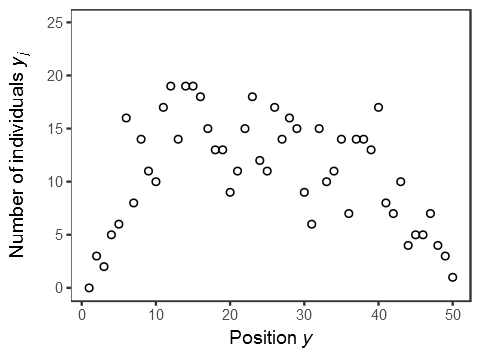

In [36]:
# Fig. 11.2
data_frame(j = seq_along(Y), y = Y) %>>% 
    ggplot(aes(x = j, y = y)) + 
    geom_point(shape = 21)+ 
    theme_bw() +
    theme(panel.grid = element_blank()) + 
    xlab(expression("Position "*italic("y"))) + 
    ylab(expression("Number of individuals  "*italic("y")[italic("j")])) + 
    ylim(c(0, 25))

## 11.2 階層ベイズモデルに空間構造をくみこむ

個体数 $y_j$ がすべての区画で共通の平均値 $\lambda$ のポアソン分布に従うとする．

$$ p(y_j \mid \lambda) = \frac{\lambda^{y_j}\exp(-\lambda)}{y_j!} $$

標本平均は，

In [37]:
mean(Y)

[1] 10.88

10.9 ぐらいなので，分散も同じぐらいになるはずだが，標本分散は，

In [38]:
var(Y)

[1] 27.37306

27.4 ぐらいなので，過分散が生じている．

図 11.2 を見ると，個体数 $y_j$ は位置によって変化しているように見える．

区画ごとに異なる $\lambda_j$ をもつとする．
平均個体数 $\lambda_j$ を線形予測子と対数リンク関数を用いて，以下のようにあらわす．

$$\log \lambda_j =\beta + r_j$$

ここで，

* $\beta$ は切片で大域的なパラメータ => 無情報事前分布
* $r_j$ は場所差で局所的なパラメータ => 階層事前分布

### 11.2.1 空間構造のない階層事前分布

場所差 $r_j$ の階層事前分布

* 10章のようにすると，$r_j$ はどれも独立になる
    * 平均0，標準偏差s の正規分布

$$ p(r_j \mid s) = \frac{1}{\sqrt{2 \pi s^2}} \exp \left( -\frac{r_j^2}{2s^2} \right) $$

* 

### 11.2.2 空間構造のある階層事前分布

場所差$r_j$に制約を設ける

1. 場所差は「近傍」区画の場所差にしか影響されない
1. 区画$j$の近傍の個数 $n_j$ は有限個であり，どの区画が近傍であるかはあらかじめ設定する
1. 近傍の直接の影響はどれも等しく，$1 / n_j$

簡単のために，近傍数は2とする

* 両隣の影響しか受けない
* 両端については近傍数1

$r_j$ の事前分布を以下のように設定する

$$ p(r_j \mid \mu_j, s) = \sqrt{\frac{n_j}{2 \pi s^2}} \exp \left\{ -\frac{(r_j - \mu_j)^2}{2s^2 / n_j} \right\} $$

ここで，平均 
$\mu_j$ は近傍の平均値に等しいとする

$$ \mu_j = \frac{r_{j-1} + r_{j+1}}{2} $$

* 両端では，$\mu_1 = r_2$，$\mu_{50} = r_49$
* 標準偏差は $s / \sqrt{n_j}$
* $s$ はどこでも等しい 

条件つき自己回帰（Conditional Auto Regressive, CAR）モデル

のなかでも

**intristic Gaussian CAR** モデルという

場所差 $\{ r_j \} = \{ r_1, r_2, \ldots, r_{50}\}$ 全体の事前分布である同時分布は，以下のように書ける

* $j \sim j^\prime$ は$j$と $j^\prime$ が近傍であるようなすべての $\{j, j^\prime\}$ の組み合わせ

$$ p( \{r_j \} \mid s) \propto \exp \left\{ \frac{1}{2s^2} \sum\limits_{j \sim j^\prime} (r_j - r_{j^\prime})^2 \right\} $$

この同時分布において，$r_j$を除くすべての$\{ r_* \}$ を定数とおくと，条件つき事前分布 $p(r_j \mid \mu_j, s)$ が得られる．

## 11.3 空間統計モデルをデータにあてはめる

事前分布は，

$$ p(\beta, s, \{ r_j \} \mid \boldsymbol{Y}) \propto p(\{ r_j \} \mid s) p(s) p(\beta) \prod\limits_j p(y_j \mid \lambda_j) $$

* データ $y_j$ が得られる確率: 平均 $\lambda_j = \exp (\beta + r_j)$ のポアソン分布
    * $\beta$の事前分布: 無情報事前分布（$p(\beta)$）
    * $r_j$ の事前分布: 空間構造を考慮した階層事前分布（同時分布$p(\{ r_j \} \mid s)$）
* 個々の$r_j$ の条件付事前分布: 平均 $\mu_j$，標準偏差 $s/\sqrt{n_j}$の正規分布 $p(r_j \mid \mu_j, s)$
    * $s$ の事前分布: 無情報事前分布（$p(s)$）

In [41]:
readLines("chap11-model.jags", encoding = "UTF-8") %>>% cat(sep = "\n")

model
{
  for (j in 1:N.site) {
    Y[j] ~ dpois(mean[j]) # ポアソン分布
    log(mean[j]) <- beta + r[j] # （切片） + （場所差）
  }
  # 場所差 r[j] をCAR model で生成
  # car.normal()
  ## Adj[]: 隣接する場所の番号
  ## Weights[]: Adj[] に対応する重み
  ## Num[]: 隣接数 n_j
  ## tau: 分散の逆数
  r[1:N.site] ~ car.normal(Adj[], Weights[], Num[], tau)
  beta ~ dnorm(0, 1.0E-4)
  tau <- 1 / (s * s) # tau は分散の逆数
  s ~ dunif(0, 1.0E+4)
}



<img src="images/Chap11/model-jags.png" width = 600></img>

In [42]:
library(rjags)

Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


In [87]:
data.list <- list(
    N.site = length(Y), 
    Y = Y, 
    Adj = c(2, 2:(length(Y)-1), length(Y)-1) %>>% 
            purrr::map_at(c(2:49), function(x){c(x - 1, x + 1)}) %>>% 
            purrr::flatten() %>>% purrr::flatten_dbl(), 
    Weights = rep(1, 2 * length(Y) - 2), 
    Num = c(1, rep(2, length(Y) - 2), 1)
)

In [88]:
data.list

$N.site
[1] 50

$Y
 [1]  0  3  2  5  6 16  8 14 11 10 17 19 14 19 19 18 15 13 13  9 11 15 18 12 11
[26] 17 14 16 15  9  6 15 10 11 14  7 14 14 13 17  8  7 10  4  5  5  7  4  3  1

$Adj
 [1]  2  1  3  2  4  3  5  4  6  5  7  6  8  7  9  8 10  9 11 10 12 11 13 12 14
[26] 13 15 14 16 15 17 16 18 17 19 18 20 19 21 20 22 21 23 22 24 23 25 24 26 25
[51] 27 26 28 27 29 28 30 29 31 30 32 31 33 32 34 33 35 34 36 35 37 36 38 37 39
[76] 38 40 39 41 40 42 41 43 42 44 43 45 44 46 45 47 46 48 47 49 48 50 49

$Weights
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[77] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

$Num
 [1] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[39] 2 2 2 2 2 2 2 2 2 2 2 1

In [89]:
inits.list <- list(
    beta = 0, 
    r = rnorm(length(Y), 0, 0.1), 
    s = 1
)

In [90]:
inits.list

$beta
[1] 0

$r
 [1]  0.0007584825 -0.0835755815  0.0671660651  0.1106168202  0.0731544016
 [6]  0.2217949947  0.0830555192 -0.1010638539  0.0408009078  0.0001750425
[11] -0.0378588093  0.1248937609  0.0443412599 -0.1394628799 -0.0407097574
[16] -0.0150041388  0.0298765425  0.0022427322  0.1271973202  0.0329233227
[21]  0.1392462899  0.0535101863 -0.0390383061  0.0305979735  0.0349595742
[26]  0.0346877301 -0.1183028612 -0.1257006106 -0.0007915172  0.1922852728
[31] -0.0444059506 -0.0030705125  0.1681566232  0.0777691623  0.0918771511
[36]  0.2312410470 -0.0008653177 -0.1387361469  0.1071134075  0.0589376510
[41] -0.0582493442 -0.0919963772 -0.1512040054 -0.2787769830  0.0063551332
[46] -0.1479107700 -0.0907619838 -0.1283088692  0.1004261508 -0.0680991739

$s
[1] 1

`Adj[]`

* `j`: 区画番号
* `rj1`: $r_{j-1}$
* `rj2`: $r_{j+1}$

In [64]:
c(sapply(2:(50 - 1), function(a) c(a - 1, a + 1))) %>>% 
    {c(NA, 2, (.), 49, NA)} %>>%
    {matrix(data = (.), ncol = 2, byrow = TRUE)} %>>% 
    data.frame() %>>% 
    mutate(j = c(1:50)) %>>% 
    rename(r1 = X1, r2 = X2) %>>% 
    select(j, r1, r2) %>>% head()

j,r1,r2
1,NA,2
2,1,3
3,2,4
4,3,5
5,4,6
6,5,7


In [91]:
m <- jags.model(
    file = "chap11-model.jags", 
    data = data.list, 
    inits = list(inits.list, inits.list, inits.list), 
    n.chain = 3
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Deleting model



ERROR: Error in jags.model(file = "chap11-model.jags", data = data.list, inits = list(inits.list, : RUNTIME ERROR:
Compilation error on line 13.
Unknown distribution: car.normal




In [1]:
library(CARBayes)

Warning message:
: package 'CARBayes' was built under R version 3.2.5Loading required package: MASS
Loading required package: Rcpp
Warning message:
: package 'Rcpp' was built under R version 3.2.5

In [2]:
load("Y.RData")

In [7]:
ls.str()

m :  Named num [1:50] 2.15 3.25 4.63 6.23 7.99 ...
q : function (save = "default", status = 0, runLast = TRUE)  
quit : function (save = "default", status = 0, runLast = TRUE)  
Y :  num [1:50] 0 3 2 5 6 16 8 14 11 10 ...

In [13]:
options(repr.plot.width = 4, repr.plot.height = 4)

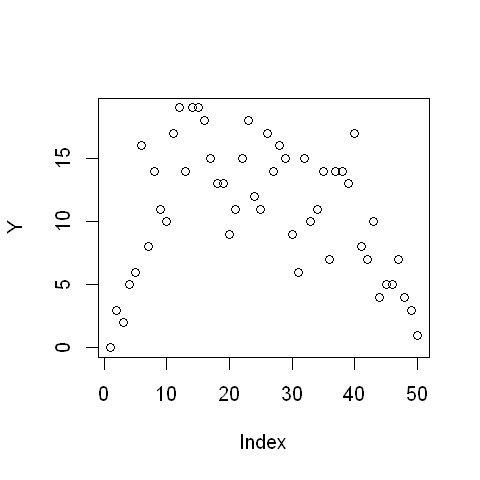

In [14]:
plot(Y)

In [10]:
n <- length(Y)
W <- matrix(0, nrow = n, ncol = n)

In [12]:
for (i in 2:n) {
    W[i, i - 1] <- W[i - 1, i] <- 1
}

In [16]:
fit <- S.CARleroux(Y ~ 1, family = "poisson", W = W, burnin = 2000, n.sample = 32000, thin = 10, 
                   fix.rho = TRUE, rho = 1)

Setting up the model
Generating 3000 post burnin and thinned (if requested) samples
  |======================================================================| 100%
Summarising results
 finished in  11.9 seconds

In [17]:
print(fit)


#################
#### Model fitted
#################
Likelihood model - Poisson (log link function) 
Random effects model - Leroux CAR
Regression equation - Y ~ 1
Number of missing observations - 

############
#### Results
############
Posterior quantities and DIC

            Median   2.5%  97.5% n.sample % accept n.effective Geweke.diag
(Intercept) 2.2785 2.1759 2.3762     3000     36.3      1398.7         0.1
tau2        0.0403 0.0166 0.0955     3000    100.0       886.3         0.5
rho         1.0000 1.0000 1.0000       NA       NA          NA          NA

DIC =  264.0276       p.d =  15.42842       LMPL =  -118.0891 


In [24]:
summarise.samples(fit$samples$beta, quantiles = c(0.025, 0.5, 0.975))

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[2]]) result is length 0


$quantiles
        0.025      0.5    0.975
[1,] 2.175914 2.278455 2.376202

$exceedences
NULL


In [25]:
summarise.samples(fit$samples$phi, quantiles = c(0.025, 0.5, 0.975))

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[2]]) result is length 0


$quantiles
             0.025         0.5       0.975
 [1,] -1.873514024 -1.12993656 -0.54437601
 [2,] -1.611533626 -1.01077005 -0.50686212
 [3,] -1.378029671 -0.85056119 -0.38836591
 [4,] -1.027426582 -0.60270372 -0.21263802
 [5,] -0.709593333 -0.34378684  0.02082262
 [6,] -0.361685300 -0.02375557  0.33954028
 [7,] -0.317016716  0.01093426  0.35476241
 [8,] -0.181162190  0.15132469  0.46760059
 [9,] -0.148094194  0.18994275  0.51817195
[10,] -0.068282589  0.25334897  0.56770933
[11,]  0.122293472  0.41757403  0.73413750
[12,]  0.213874419  0.50231565  0.82826018
[13,]  0.180404961  0.49108547  0.78952715
[14,]  0.274670027  0.56174205  0.86740232
[15,]  0.271682898  0.57074703  0.88007914
[16,]  0.207703340  0.52506796  0.82969353
[17,]  0.113320399  0.42409383  0.73646387
[18,]  0.006623007  0.33360214  0.64193039
[19,] -0.056337031  0.26134797  0.56873265
[20,] -0.141930351  0.18986296  0.50277397
[21,] -0.084218568  0.23841116  0.55092470
[22,]  0.024748393  0.33748548  0.66795699


In [26]:
library(coda)

In [28]:
options(repr.plot.width = 8, repr.plot.height = 4)


Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

  var1 
0.1291 



Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

    var1     var2     var3     var4     var5     var6     var7     var8 
-0.34116 -0.57816 -0.73763 -0.32553 -1.47898 -1.12609 -0.82692 -0.62463 
    var9    var10    var11    var12    var13    var14    var15    var16 
-0.13057 -0.43927  1.10608  1.41709 -0.48188 -1.18639  0.01796  1.01476 
   var17    var18    var19    var20    var21    var22    var23    var24 
-0.77696 -0.18862 -0.48363 -0.05169  1.64104  0.98021  1.28074  0.53259 
   var25    var26    var27    var28    var29    var30    var31    var32 
 1.53644  0.76069 -1.04678 -1.08163 -1.19937 -1.95869 -1.57646 -0.02234 
   var33    var34    var35    var36    var37    var38    var39    var40 
-0.41445  0.43283  0.71277  0.35323  1.22731  1.25896  1.35435  1.11815 
   var41    var42    var43    var44    var45    var46    var47    var48 
 2.46660  1.37217  1.88750  1.47119  0.18793  0.43442  0.37979 -0.33664 
   var49    var50 
-1.65593 -1.31549 


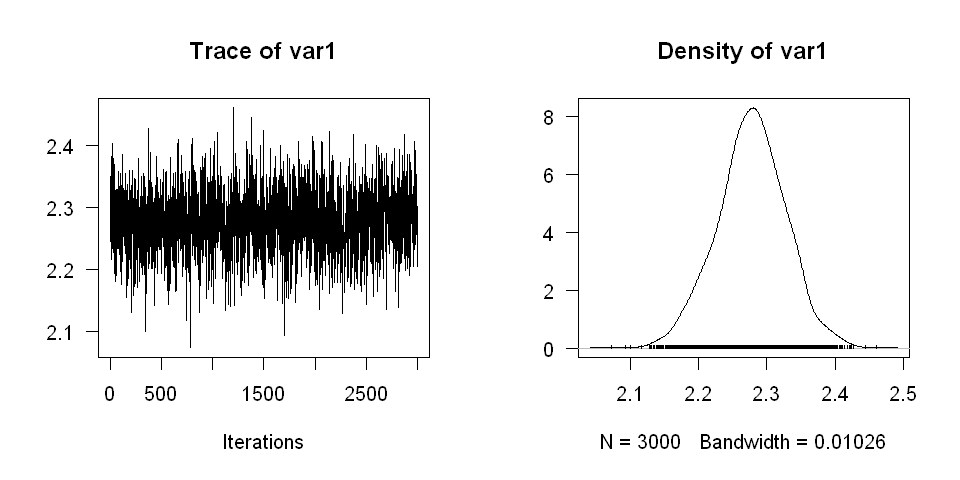

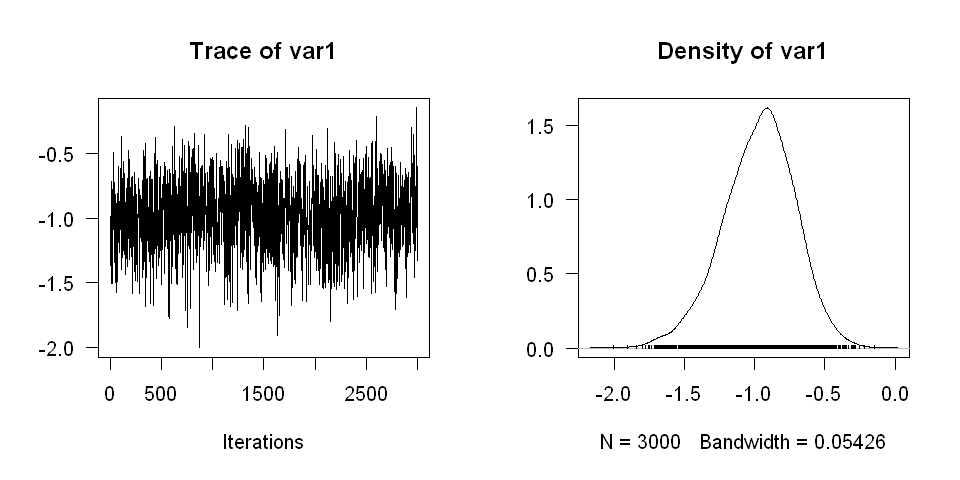

In [29]:
geweke.diag(fit$samples$beta)
geweke.diag(fit$samples$phi)

plot(fit$samples$beta, las = 1)
plot(fit$samples$phi[,49], las = 1)


In [32]:
sapply(c("ggplot2", "Cairo"), require, character.only = TRUE)

Loading required package: ggplot2


ggplot2   Cairo 
   TRUE    TRUE

In [36]:
options(repr.plot.width = 4, repr.plot.height = 4)

In [44]:
seq_along(c(1,10, 20))

[1] 1 2 3

pdf 
  2

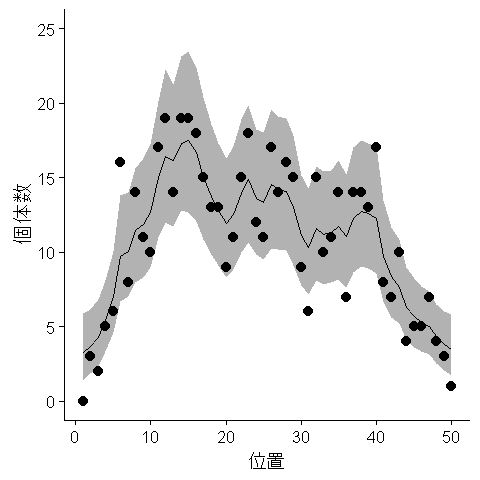

In [37]:
point.alpha <- 0.5
ribbon.alpha <- 0.3
ribbon.fill <- "black"
Y.fit <- apply(fit$samples$fitted, 2, mean) #3000回の平均
Y.ci <- apply(fit$samples$fitted, 2, quantile, c(0.025, 0.975))

df <- data.frame(j = seq_along(Y), Y = Y, Yhat = Y.fit,
                  Yupper = Y.ci["97.5%", ], Ylower = Y.ci["2.5%", ])
p <- ggplot(df) +
  geom_ribbon(aes(x = j, ymax = Yupper, ymin = Ylower),
              fill = ribbon.fill, alpha = ribbon.alpha) +
  geom_point(aes(x = j, y = Y), size = 2.5) +
  geom_line(aes(x = j, y = Yhat), size = 0.5) +
  xlab("位置") + ylab("個体数") +
  ylim(0, 25) +
  theme_classic(base_family = "IPAexGothic")

Cairo(type = "raster")
print(p)
dev.off()

In [40]:
str(fit$samples$fitted)

 mcmc [1:3000, 1:50] 4.14 3.13 3.24 3.5 3.85 ...
 - attr(*, "mcpar")= num [1:3] 1 3000 1


In [41]:
head(fit$samples$fitted, 5)

Markov Chain Monte Carlo (MCMC) output:
Start = 1 
End = 6 
Thinning interval = 1 
         [,1]     [,2]     [,3]     [,4]     [,5]      [,6]      [,7]      [,8]
[1,] 4.139233 4.156841 4.213303 5.218725 7.902249 11.265544 14.142301 12.504794
[2,] 3.129591 4.216136 3.344140 4.774768 5.824074  9.092956 11.200192 14.187043
[3,] 3.236946 3.895801 4.363798 6.126297 5.136854  7.734121  9.958668 13.840372
[4,] 3.497460 3.890900 4.422469 5.877132 6.028217  7.633943  9.050310 10.964479
[5,] 3.852006 4.323871 3.107779 5.489970 6.480753 13.441905  9.883048  7.885837
[6,] 2.809432 4.451612 4.922996 5.355413 6.523076 10.861404 12.284265 10.859760
         [,9]    [,10]    [,11]    [,12]    [,13]    [,14]    [,15]    [,16]
[1,] 11.88237 13.43277 20.53082 19.98986 19.24062 20.54030 23.03319 14.72884
[2,] 13.56578 13.91570 16.38037 17.55273 16.98178 19.08721 14.55503 13.41968
[3,] 16.71814 14.91655 15.21827 17.52191 14.79813 20.48789 17.22653 15.28856
[4,] 12.72486 10.63542 12.62310 17.36524 17.02902

In [22]:
print(readLines("runbugs.R"))

 [1] "source(\"R2WBwrapper.R\")"                                    
 [2] "clear.data.param()"                                           
 [3] ""                                                             
 [4] "load(\"Y.RData\")"                                            
 [5] "set.data(\"N.site\", length(Y))"                              
 [6] "set.data(\"Y\", Y)"                                           
 [7] ""                                                             
 [8] "Adj <- c(sapply(2:(N.site - 1), function(a) c(a - 1, a + 1)))"
 [9] "set.data(\"Adj\", c(2, Adj, N.site - 1))"                     
[10] "set.data(\"Weights\", rep(1, 2 * N.site - 2))"                
[11] "set.data(\"Num\", c(1, rep(2, N.site - 2), 1))"               
[12] ""                                                             
[13] "set.param(\"beta\", 0)"                                       
[14] "set.param(\"r\", rnorm(N.site, 0, 0.1))"                      
[15] "set.param(\"s\", 1)"        